<a href="https://colab.research.google.com/github/sayan0506/Face-Recognition-pipeline-using-SOTA-ArcFace/blob/main/Face_recognition_using_arcface.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Face recognition Pipeline design using arcface**

This notebook is inspired from the paper [ArcFace: Additive Angular Margin Loss for Deep Face Recognition](https://arxiv.org/pdf/1801.07698v3.pdf)

Git repo: [Insightface_Pytorch](https://github.com/TreB1eN/InsightFace_Pytorch)

**Install Dependencies**

In [1]:
# install tensorboardX
!pip install tensorboardX

     |████████████████████████████████| 122kB 34.4MB/s 


## **Mount Drive**

Drive: [link](hazrasayan2021@gmail.com)

In [2]:
from google.colab import drive

drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


## **Import Dependencies**

In [3]:
from pathlib import Path
import numpy as np
import cv2
import os
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

# data pipeline
# helps to create dict where, use keys as atribute
from easydict import EasyDict as edict

from torchvision import transforms as trans
from torchvision.datasets import ImageFolder
from PIL import Image, ImageFile, ImageDraw
from torch.utils.data import Dataset, DataLoader

# ensures loading truncated images 
ImageFile.LOAD_TRUNCATED_IMAGES = True

# model build
from torch.nn import Linear, Conv2d, BatchNorm1d, BatchNorm2d, PReLU, ReLU, Sigmoid, Dropout2d, Dropout, AvgPool2d, MaxPool2d, AdaptiveAvgPool2d, Sequential, Module, Parameter
import torch.nn.functional as F
import torch
from collections import namedtuple
import math
import pdb

# model training
from tensorboardX import SummaryWriter
from torch import optim
from gdrive.MyDrive.arcface import model
from tqdm import tqdm
from torch.nn import CrossEntropyLoss

## **Environment Setup**

**Check GPU utilization**

In [6]:
#!export CUDA_VISIBLE_DEVICES=""

In [7]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f'Running on device: {device}')

Running on device: cuda:0


In [8]:
print(f'Device info\n{torch.cuda.get_device_properties(0)}')

Device info
_CudaDeviceProperties(name='Tesla T4', major=7, minor=5, total_memory=15109MB, multi_processor_count=40)


## **Dataset Load and Train-Valid-Test**

Load the avengers face dataset
* Source: [Kaggle](https://www.kaggle.com/rawatjitesh/avengers-face-recognition)
* Drive link: [Dataset](https://drive.google.com/drive/folders/1VYuEXVOzUtd7fOaaLv7oW4YwGYbvh80w?usp=sharing)

**Defining Configuration Dictionary, which will contain the important metadata regarding the ML pipeline**

In [9]:
# config edict dictionary initialize
config = edict()

In [10]:
# configure device
config.device = device

In [11]:
# avengers face dataset path
dataset_path = "/content/gdrive/MyDrive/Kaggle Avengers face dataset/Marvels_face_dataset"
# add dataset path to config
config.imgs_folder = dataset_path

#### **Data Analysis**

In [12]:
# identity list
identity_list = ['chris_evans', 'chris_hemsworth', 'mark_ruffalo', 'robert_downey_jr', 'scarlett_johansson']
# identity path
identity_path = [os.path.join(config.imgs_folder, identity) for identity in identity_list]

print(f'Identity Paths\n{identity_path}')

Identity Paths
['/content/gdrive/MyDrive/Kaggle Avengers face dataset/Marvels_face_dataset/chris_evans', '/content/gdrive/MyDrive/Kaggle Avengers face dataset/Marvels_face_dataset/chris_hemsworth', '/content/gdrive/MyDrive/Kaggle Avengers face dataset/Marvels_face_dataset/mark_ruffalo', '/content/gdrive/MyDrive/Kaggle Avengers face dataset/Marvels_face_dataset/robert_downey_jr', '/content/gdrive/MyDrive/Kaggle Avengers face dataset/Marvels_face_dataset/scarlett_johansson']


**Define image and label dataframe for analysis**

In [13]:
# image dataframe
img_df = pd.DataFrame(columns = ['Image', 'Label'])

# label dataframe
label_df = pd.DataFrame(columns = identity_list)

**Fetching info**

In [14]:

print('\n[INFO] Loading images ...')
# total sample count
sample_count = 0
for sr, id_path in enumerate(identity_path):
  print(f'[INFO] Processing {identity_list[sr]}')
  sample_list = os.listdir(id_path)

  for id_sample in sample_list:
    # removing the .DS_store files from list, which contains the folder infos
    if id_sample == '.DS_store':
      sample_list.remove(id_sample)
  # categorical count
  count = 0
  for id_sample in sample_list:
    id_sample_path = os.path.join(id_path, id_sample)
    if id_sample_path.endswith(".jpg") == True or id_sample_path.endswith(".JPG") == True or id_sample_path.endswith(".png") == True or id_sample_path.endswith(".PNG") == True:
      img_df.loc[sample_count,'Image'], img_df.loc[sample_count,'Label'] = id_sample, identity_list[sr]
      #self.img_df.loc[sample_count,'Shape'] = img.shape
      count += 1
      sample_count += 1

  label_df.loc[0, identity_list[sr]] = count
  print(count)
  # checks whether all the samples are loaded successfully or not to img_df
  assert len(sample_list) == count

print(f'Data distribution of different identities\n{label_df}')
print(f'Image dataframe\n{img_df}')


[INFO] Loading images ...
[INFO] Processing chris_evans
50
[INFO] Processing chris_hemsworth
53
[INFO] Processing mark_ruffalo
66
[INFO] Processing robert_downey_jr
51
[INFO] Processing scarlett_johansson
54
Data distribution of different identities
  chris_evans chris_hemsworth mark_ruffalo robert_downey_jr scarlett_johansson
0          50              53           66               51                 54
Image dataframe
                        Image               Label
0           chris_evans34.png         chris_evans
1           chris_evans32.png         chris_evans
2            chris_evans6.png         chris_evans
3           chris_evans47.png         chris_evans
4           chris_evans13.png         chris_evans
..                        ...                 ...
269  scarlett_johansson54.png  scarlett_johansson
270  scarlett_johansson52.png  scarlett_johansson
271   scarlett_johansson9.png  scarlett_johansson
272  scarlett_johansson53.png  scarlett_johansson
273   scarlett_johansson5

**Target Distribution Visualize**

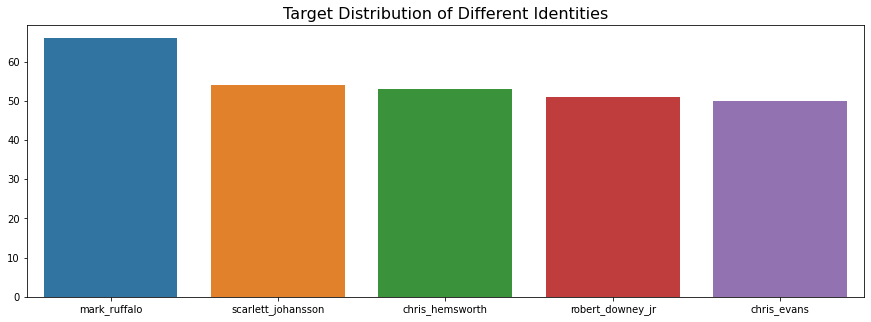

In [15]:
def distribution_vis(counts_series, label):
  '''
  Target distribution
  '''
  fig = plt.figure(figsize = (15,5))
  sns.barplot(x = counts_series.index, y = counts_series.values)
  plt.title(label, fontsize = 16)

# returns pandas series with classes as keys and count as values
target_counts = img_df['Label'].value_counts()

# vis distribution
distribution_vis(target_counts, label = 'Target Distribution of Different Identities')

#### **Train-Validation-Test Split**

We are taking train, valid, test ratio as - [0.9:0.05:0.05]

In [16]:
# validation split
val_ratio = 0.10
# test split
test_ratio = 0.5

# image_ids
img_ids = img_df.loc[:,'Image']

# image_ids
label_ids = img_df.loc[:,'Label']

**Defining train, validation, test dataframe**

In [17]:
# train df
train_df = pd.DataFrame(columns=['Image','Label'])
# validation main df
valid_main_df = pd.DataFrame(columns=['Image','Label'])
# validation df
valid_df = pd.DataFrame(columns=['Image','Label'])
# test df
test_df = pd.DataFrame(columns=['Image','Label'])

**Train-Valid_main Split**

In [18]:
train_df['Image'], valid_main_df['Image'], train_df['Label'], valid_main_df['Label'] = train_test_split(img_ids, label_ids,
                                                                                                      test_size = val_ratio,
                                                                                                      random_state = 28,
                                                                                                      stratify = label_ids,
                                                                                                      shuffle = True
                                                                                                      )

**Validation-Test Split**

In [19]:
valid_df['Image'], test_df['Image'], valid_df['Label'], test_df['Label'] = train_test_split(valid_main_df['Image'], valid_main_df['Label'],
                                                                                                      test_size = test_ratio,
                                                                                                      random_state = 28,
                                                                                                      stratify = valid_main_df['Label'],
                                                                                                      shuffle = True
                                                                                                      )

In [20]:
print(f'Train dataframe shape {train_df.shape}')
print(f'Validation dataframe shape {valid_df.shape}')
print(f'Test dataframe shape {test_df.shape}')

Train dataframe shape (246, 2)
Validation dataframe shape (14, 2)
Test dataframe shape (14, 2)


**STratification Check**

In [21]:
def distribution_vis_check(train, valid, test):
  '''
  Target distribution
  '''
  xdf = [train.index, valid.index, test.index]
  ydf = [train.values, valid.values, test.values]
  label = ['Train Distribution', 'Validation Distribution', 'Test Distribution'] 
  fig = plt.figure(figsize = (20,5))
  for i in range(len(xdf)):
    fig.add_subplot(1, len(xdf), i+1)
    sns.barplot(x = xdf[i], y = ydf[i])
    plt.xlabel(label[i], fontsize = 16)


**Startifiction check using the df**

In [22]:
print(train_df['Label'].value_counts())
print(valid_df['Label'].value_counts())
print(test_df['Label'].value_counts())

mark_ruffalo          59
chris_hemsworth       48
scarlett_johansson    48
robert_downey_jr      46
chris_evans           45
Name: Label, dtype: int64
mark_ruffalo          4
chris_evans           3
scarlett_johansson    3
robert_downey_jr      2
chris_hemsworth       2
Name: Label, dtype: int64
robert_downey_jr      3
scarlett_johansson    3
chris_hemsworth       3
mark_ruffalo          3
chris_evans           2
Name: Label, dtype: int64


**Startification CHek Visualize**

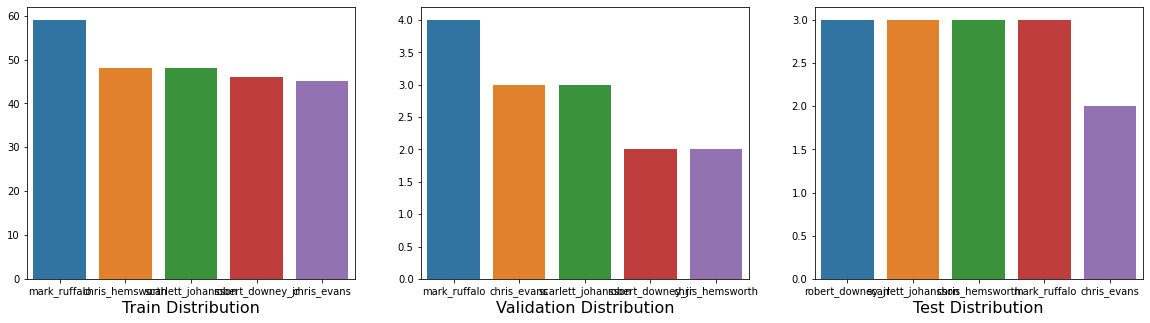

In [23]:
distribution_vis_check(train_df['Label'].value_counts(), valid_df['Label'].value_counts(), test_df['Label'].value_counts())

**From all the above analysis, the data train-valid-test split is stratified**

#### **Face Extraction**

For face detection in the images we are using pre-trained Joint Face Detection and Alignment using Multi-task Cascaded Convolutional Networks.

[Reference paper](https://arxiv.org/abs/1604.02878)

Git clone facenet_pytorch, which consists MTCNN face detector

[Git repo](https://github.com/timesler/facenet-pytorch)



In [24]:
!git clone https://github.com/timesler/facenet-pytorch

Cloning into 'facenet-pytorch'...
remote: Enumerating objects: 1264, done.
remote: Counting objects: 100% (29/29), done.
remote: Compressing objects: 100% (27/27), done.
remote: Total 1264 (delta 11), reused 7 (delta 2), pack-reused 1235
Receiving objects: 100% (1264/1264), 22.89 MiB | 46.14 MiB/s, done.
Resolving deltas: 100% (613/613), done.


**Rename folder to "facenet_pytorch", as python module does not accept name containing "-"**

In [25]:
os.rename('facenet-pytorch', 'facenet_pytorch')

**Import Dependencies for MTCNN face detector**

In [26]:
from facenet_pytorch.models.mtcnn import MTCNN

**Define MTCNN module**

Default params shown for illustration, but not needed. Note that, since MTCNN is a collection of neural nets and other code, the device must be passed in the following way to enable copying of objects when needed internally.

In [27]:
# face detector object
# using default reshaped face size = (160,160)
mtcnn = MTCNN(
    image_size=160, margin=0, min_face_size=20,
    thresholds=[0.6, 0.7, 0.7], factor=0.709, post_process=True,
    device=config.device
)

**Demo Detection**

face count in the sample is 1 with confidence 99.45905208587646%

Done Detection


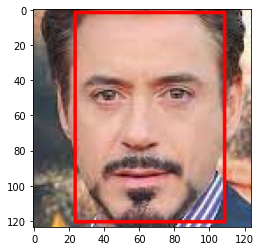

In [28]:
sample_img = 'robert_downey_jr9.png' 

# read using PIL library, else ImagDraw will not work here
img = Image.open(os.path.join(config.imgs_folder, 'robert_downey_jr', sample_img))

# detect faces
boxes, prob = mtcnn.detect(img)

# draw faces
img_draw = img.copy()

# define draw object to draw on the image
draw = ImageDraw.Draw(img_draw)
for box in boxes:
  draw.rectangle(box.tolist(), outline = (255,0,0), width = 2)
print(f'face count in the sample is {len(boxes)} with confidence {prob[0]*100}%')

print('\nDone Detection')

plt.imshow(img_draw)
plt.show()

## **Create Torch Dataset**

**Configure input image size**

In [29]:
config.input_size = (112,112)

**Define custom FcaeDataset class to obtain samples from train, valid, test dataframe**

In [30]:
class FaceDataset(Dataset):
  def __init__(self, df, root_dir, identity_list, transform = None):
    self.df = df
    self.dir = root_dir
    self.transform = transform
    self.identity = identity_list
  
  def __len__(self):
    return self.df.shape[0]

  def __getitem__(self, idx):
    if torch.is_tensor(idx):
      idx = idx.tolist()
    img_name = os.path.join(self.dir, self.df['Label'].iloc[idx], self.df['Image'].iloc[idx])
    sample = [Image.open(img_name), int(self.identity.index(self.df['Label'].iloc[idx]))]

    if self.transform:
      sample[0] = self.transform(sample[0])
    
    sample = tuple(sample)

    return sample


**Configure Identity list, train_dataframe, valid_dataframe, test_dataframe**

In [31]:
config.identity = identity_list
config.train_df = train_df
config.valid_df = valid_df
config.test_df = test_df

**Define and configure transform for train, valid, test**

Define same transform for train, valid, test using torcgvision transform

In [32]:
# configure transform
config.transform = trans.Compose([
                                   trans.RandomHorizontalFlip(), # random horizonttal flip of faces
                                   trans.ToTensor(), # convert img to torch tensor
                                   trans.Normalize([0.5,0.5,0.5], [0.5,0.5,0.5]), # normalize
                                   trans.Resize(config.input_size, interpolation=trans.InterpolationMode.BICUBIC)
  ])

**Create train dataset from the train dataframe**

In [33]:
def get_dataset(config, df):
  # fetch and transform the images using torchvision transforms to create dataset
  # from the image folder
  ds = FaceDataset(df, config.imgs_folder, config.identity, transform= config.transform)
  class_num = len(config.identity) # total class is the index of last folder + 1
  return ds, class_num

# create train dataset
train_ds, train_class_num = get_dataset(config, config.train_df)

In [34]:
targets = [train_ds.identity.index(id) for id in train_ds.identity]

In [35]:
print(f'Train Dataset info {train_ds},\ncontains {train_class_num} different identities!')
print(f'Classes available in the dataset \n{train_ds.identity},\nhaving class ids {targets} respectively!')
print(f'Length of the dataset {len(train_ds)}')

Train Dataset info <__main__.FaceDataset object at 0x7f5aa593db90>,
contains 5 different identities!
Classes available in the dataset 
['chris_evans', 'chris_hemsworth', 'mark_ruffalo', 'robert_downey_jr', 'scarlett_johansson'],
having class ids [0, 1, 2, 3, 4] respectively!
Length of the dataset 246


**Create validation dataset from the validation dataframe**

In [36]:
# create validation dataset
valid_ds, valid_class_num = get_dataset(config, config.valid_df)

In [37]:
print(f'Validation Dataset info {valid_ds},\ncontains {valid_class_num} different identities!')
print(f'Classes available in the dataset \n{valid_ds.identity},\nhaving class ids {targets} respectively!')
print(f'Length of the dataset {len(valid_ds)}')

Validation Dataset info <__main__.FaceDataset object at 0x7f5aa594f150>,
contains 5 different identities!
Classes available in the dataset 
['chris_evans', 'chris_hemsworth', 'mark_ruffalo', 'robert_downey_jr', 'scarlett_johansson'],
having class ids [0, 1, 2, 3, 4] respectively!
Length of the dataset 14


**Create test dataset from the validation dataframe**

In [38]:
# create test dataset
test_ds, test_class_num = get_dataset(config, config.test_df)

In [39]:
print(f'Test Dataset info {test_ds},\ncontains {test_class_num} different identities!')
print(f'Classes available in the dataset \n{test_ds.identity},\nhaving class ids {targets} respectively!')
print(f'Length of the dataset {len(test_ds)}')

Test Dataset info <__main__.FaceDataset object at 0x7f5aa5942790>,
contains 5 different identities!
Classes available in the dataset 
['chris_evans', 'chris_hemsworth', 'mark_ruffalo', 'robert_downey_jr', 'scarlett_johansson'],
having class ids [0, 1, 2, 3, 4] respectively!
Length of the dataset 14


#### **Define Pytorch DataLoader**

Define the data_loader function, where we can pass dataset mode(as 'vgg' or 'ms1m') through configuration dictionary.


In [40]:
# define the train_loader function, where we can pass dataset mode(as 'vgg' or 'ms1m') through configuration dictionary
def get_data_loader(ds, class_num, config):
  if config.data_mode in ['ms1m','vgg']:
    # create train_loader, by deafult shuffles the datapoints
    data_loader = DataLoader(ds, batch_size=config.batch_size, shuffle = True, pin_memory = config.pin_memory,
                              num_workers = config.num_workers)
    return data_loader, class_num

**Defining metadata parameters to config**

In [41]:
# initializing data_mode as 'ms1m' dataset
config.data_mode = 'ms1m'
# initializing batch_size to 64
config.batch_size = 64
# pin_memory status is set to True, which enables to load samples of data to device(GPU), spped-up the training
config.pin_memory = True
# initializing the number of workers to 3
config.num_workers = 3

**Create the train dataloader**

In [42]:
train_loader, _ = get_data_loader(train_ds, train_class_num, config)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


**Create the validation dataloader**

In [43]:
valid_loader, _ = get_data_loader(valid_ds, valid_class_num, config)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


**Create the test dataloader**

In [44]:
test_loader, _ = get_data_loader(test_ds, test_class_num, config)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


## **ArcFace Model Build**

There are Backbone, Mobilefacenet models for generating face embedding. But, We are considering to use only Mobilefacenet, as it's a light-weight model.

**Define Flatten Block**

In [45]:
# flatten block
class Flatten(Module):
  def forward(self, input):
    return input.view(input.size(0), -1)

**Define L2_norm block**

In [46]:
def l2_norm(input, axis = 1):
  norm = torch.norm(input, 2, axis, True)
  output = torch.div(input, norm)
  return output

**Define a Convolution Block**

In [47]:
# defining torch deafult sub-class api
# PReLU - Parameterized ReLU used to handle the variations(parameterize activation @ x< 0) in lower level layers 
class Conv_block(Module):
    def __init__(self, in_c, out_c, kernel=(1, 1), stride=(1, 1), padding=(0, 0), groups=1):
        super(Conv_block, self).__init__()
        self.conv = Conv2d(in_c, out_channels=out_c, kernel_size=kernel, groups=groups, stride=stride, padding=padding, bias=False)
        self.bn = BatchNorm2d(out_c)
        self.prelu = PReLU(out_c)
    
    # forward prop
    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.prelu(x)
        return x

**Define Linear Block**

In [48]:
class Linear_block(Module):
    def __init__(self, in_c, out_c, kernel=(1, 1), stride=(1, 1), padding=(0, 0), groups=1):
        super(Linear_block, self).__init__()
        self.conv = Conv2d(in_c, out_channels=out_c, kernel_size=kernel, groups=groups, stride=stride, padding=padding, bias=False)
        self.bn = BatchNorm2d(out_c)
    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        return x

**Define Depthwise Seperable Convolution Block**

In [49]:
class Depth_Wise(Module):
     def __init__(self, in_c, out_c, residual = False, kernel=(3, 3), stride=(2, 2), padding=(1, 1), groups=1):
        super(Depth_Wise, self).__init__()
        self.conv = Conv_block(in_c, out_c=groups, kernel=(1, 1), padding=(0, 0), stride=(1, 1))
        self.conv_dw = Conv_block(groups, groups, groups=groups, kernel=kernel, padding=padding, stride=stride)
        self.project = Linear_block(groups, out_c, kernel=(1, 1), padding=(0, 0), stride=(1, 1))
        self.residual = residual
     def forward(self, x):
        if self.residual:
            short_cut = x
        x = self.conv(x)
        x = self.conv_dw(x)
        x = self.project(x)
        if self.residual:
            output = short_cut + x
        else:
            output = x
        return output

**Define Residual Block**

In [50]:
class Residual(Module):
    def __init__(self, c, num_block, groups, kernel=(3, 3), stride=(1, 1), padding=(1, 1)):
        super(Residual, self).__init__()
        modules = []
        for _ in range(num_block):
            modules.append(Depth_Wise(c, c, residual=True, kernel=kernel, padding=padding, stride=stride, groups=groups))
        self.model = Sequential(*modules)
    def forward(self, x):
        return self.model(x)


**Define the embedding-size in the config**

In [51]:
config.embedding_size = 512

#### **Define Mobilefacenet Model**

In [52]:
class MobileFaceNet(Module):
    def __init__(self, embedding_size):
        super(MobileFaceNet, self).__init__()
        self.conv1 = Conv_block(3, 64, kernel=(3, 3), stride=(2, 2), padding=(1, 1))
        self.conv2_dw = Conv_block(64, 64, kernel=(3, 3), stride=(1, 1), padding=(1, 1), groups=64)
        self.conv_23 = Depth_Wise(64, 64, kernel=(3, 3), stride=(2, 2), padding=(1, 1), groups=128)
        self.conv_3 = Residual(64, num_block=4, groups=128, kernel=(3, 3), stride=(1, 1), padding=(1, 1))
        self.conv_34 = Depth_Wise(64, 128, kernel=(3, 3), stride=(2, 2), padding=(1, 1), groups=256)
        self.conv_4 = Residual(128, num_block=6, groups=256, kernel=(3, 3), stride=(1, 1), padding=(1, 1))
        self.conv_45 = Depth_Wise(128, 128, kernel=(3, 3), stride=(2, 2), padding=(1, 1), groups=512)
        self.conv_5 = Residual(128, num_block=2, groups=256, kernel=(3, 3), stride=(1, 1), padding=(1, 1))
        self.conv_6_sep = Conv_block(128, 512, kernel=(1, 1), stride=(1, 1), padding=(0, 0))
        self.conv_6_dw = Linear_block(512, 512, groups=512, kernel=(7,7), stride=(1, 1), padding=(0, 0))
        self.conv_6_flatten = Flatten()
        self.linear = Linear(512, embedding_size, bias=False)
        self.bn = BatchNorm1d(embedding_size)
    
    def forward(self, x):
        out = self.conv1(x)

        out = self.conv2_dw(out)

        out = self.conv_23(out)

        out = self.conv_3(out)
        
        out = self.conv_34(out)

        out = self.conv_4(out)

        out = self.conv_45(out)

        out = self.conv_5(out)

        out = self.conv_6_sep(out)

        out = self.conv_6_dw(out)

        out = self.conv_6_flatten(out)

        out = self.linear(out)

        out = self.bn(out)
        return l2_norm(out)

**Initialize the Mobilefacenet model**

In [53]:
# call model object
mobilefacenet_model = model.MobileFaceNet(embedding_size= config.embedding_size).to(config.device)

#print(f'Model summary:\n{mobilefacenet_model}')

#### **Define Arcface Head**

Implementation of **additive margin softmax** loss in https://arxiv.org/abs/1801.05599

In [54]:
class Arcface(Module):
    # implementation of additive margin softmax loss in https://arxiv.org/abs/1801.05599
    # total class is set to deafult as the original dataset    
    def __init__(self, embedding_size=512, classnum=51332,  s=64., m=0.5):
        super(Arcface, self).__init__()
        self.classnum = classnum
        self.kernel = Parameter(torch.Tensor(embedding_size,classnum))
        # initial kernel
        self.kernel.data.uniform_(-1, 1).renorm_(2,1,1e-5).mul_(1e5)
        self.m = m # the margin value, default is 0.5
        self.s = s # scalar value default is 64, see normface https://arxiv.org/abs/1704.06369
        self.cos_m = math.cos(m)
        self.sin_m = math.sin(m)
        self.mm = self.sin_m * m  # issue 1
        self.threshold = math.cos(math.pi - m)
    def forward(self, embbedings, label):
        # weights norm
        nB = len(embbedings)
        kernel_norm = l2_norm(self.kernel,axis=0)
        # cos(theta+m)
        cos_theta = torch.mm(embbedings,kernel_norm)
#         output = torch.mm(embbedings,kernel_norm)
        cos_theta = cos_theta.clamp(-1,1) # for numerical stability
        cos_theta_2 = torch.pow(cos_theta, 2)
        sin_theta_2 = 1 - cos_theta_2
        sin_theta = torch.sqrt(sin_theta_2)
        cos_theta_m = (cos_theta * self.cos_m - sin_theta * self.sin_m)
        # this condition controls the theta+m should in range [0, pi]
        #      0<=theta+m<=pi
        #     -m<=theta<=pi-m
        cond_v = cos_theta - self.threshold
        cond_mask = cond_v <= 0
        keep_val = (cos_theta - self.mm) # when theta not in [0,pi], use cosface instead
        cos_theta_m[cond_mask] = keep_val[cond_mask]
        output = cos_theta * 1.0 # a little bit hacky way to prevent in_place operation on cos_theta
        idx_ = torch.arange(0, nB, dtype=torch.long)
        output[idx_, label] = cos_theta_m[idx_, label]
        output *= self.s # scale up in order to make softmax work, first introduced in normface
        return output

## **Model Training**

**Define to read bin of parameters**

In [55]:
def seperate_bn_paras(modules):
  # if modules is not object or instantiated
  if not isinstance(modules, list):
    modules = [*modules.modules()]
  paras_only_bn = []
  paras_wo_bn = []
  for layer in modules:
    if 'model' in str(layer.__class__):
      continue
    if 'container' in str(layer.__class__):
      continue
    else:
      if 'batchnorm' in str(layer.__class__):
        # takes bin of parameters
        paras_only_bn.extend([*layer.parameters()])
      else:
        paras_wo_bn.extend([*layer.parameters()])
  return paras_only_bn, paras_wo_bn


**Configure saved model path**

In [56]:
config.save_path = 'saved_model'

if not os.path.isdir(config.save_path):
  os.mkdir(config.save_path)

**Initialize training and define training parameters**

In [90]:
class face_learner(object):
  def __init__(self, config, model, train_loader, train_class_num, inference = False):
    print(f'Configureation-\n{config}')
    # if we want to load MobileFcaenet model
    if config.use_mobilefacenet:
      # model already loaded to device
      self.model = model
      print('MobilefaceNet model generated!')
    else:
      print('Load the different model!')
    
    # defines the milestones where, the lr_scheduler will act
    self.milestones = config.milestones
    self.val_loader, self.val_class_num = valid_loader, valid_class_num
    self.loader, self.class_num = train_loader, train_class_num

    # helps to log summary of training using TensorboardX
    #self.writer = SummaryWriter(config.log_path)
    self.step = 0
    self.head = Arcface(embedding_size=config.embedding_size, classnum=self.class_num).to(device)

    print('Two model heads generated!')

    paras_only_bn, paras_wo_bn = seperate_bn_paras(self.model)   
    #print(len(paras_only_bn))
    #print(len(paras_wo_bn))
    # define optimizer for mobilefacenet
    if config.use_mobilefacenet:
      self.optimizer = optim.SGD([
                                  {'params': paras_wo_bn[:-1], 'weight_decay': 4e-05},# weight decay for the params
                                  {'params': [paras_wo_bn[-1]] + [self.head.kernel], 'weight_decay': 4e-04},
                                  {'params': paras_only_bn}
      ], lr = config.lr, momentum = config.momentum)
    
    else:
      self.optimizer = optim.SGD([
                                  {'params': paras_wo_bn + [self.head.kernel], 'weight_decay': 5e-04},
                                  {'params': paras_only_bn}
      ], lr = config.lr, momentum = config.momentum)
  
    print(self.optimizer)
    
    print('Optimizers generated')
    # log loss to every (len of loader//100) step
    self.board_loss_every = len(self.loader)//100
    # evaluate every (len of loader//10) step
    self.evaluate_every = len(self.loader)//10
    # save after (len(loader)//5) step
    self.save_every = len(self.loader)//5
    
  # lr scheduler
  def schedule_lr(self):
    for params in self.optimizer.param_groups:
      params['lr']/=10
    print(self.optimizer)

  # save state of the model
  def save_state(self, config, loss, model_only = False):
    # save to model to config path
    save_path = config.save_path

    torch.save(
        self.model.state_dict(), os.path.join(save_path, 
        f'model_step_{self.step}_loss_{loss}.path'))
    
    if not model_only:
      torch.save(
          self.head.state_dict(), os.path.join(save_path, f'head_step_{self.step}_loss_{loss}.path')
      )

      torch.save(
          self.optimizer.state_dict(), os.path.join(save_path,
                                                    f'optimizer_step_{self.step}_loss_{loss}.path')
      )

  # load the state from saved model
  def load_state(self, config, fixed_str, from_save_folder = False, model_only = False):
    if from_save_folder:
      load_save_path = config.save_path
    else:
      load_save_path = config.model_path
    self.model.load_state_dict(torch.load(save_path/'model_{}'.format(fixed_str)))
    if not model_only:
      self.head.load_state_dict(torch.load(save_path/'head_{}'.format(fixed_str)))
      self.optimizer.load_state_dict(torch.load(save_path/'optimizer_{}'.format(fixed_str)))


**Configure metadata for training**

In [80]:
# define work_space 
config.work_path = Path('work_space/')

# create work_space path, if not existed
if not os.path.isdir(config.work_path):
  os.mkdir(config.work_path)

# configure logpath
config.log_path = config.work_path/'log'

# create log path, if not existed
#if not os.path.isdir(config.work_path/'log'):
#  os.mkdir(config.work_path/'log')

# configure mobilefacenet status
config.use_mobilefacenet = True

# configure milestones
config.milestones = [12,15,18]

# configure momentum
config.momentum = 0.9

# configure learning rate
config.lr = 1e-03

# loss fn
config.ce_loss = CrossEntropyLoss()

#### **Define Model Train**

In [88]:
def train(config, epochs):
  learner = face_learner(config, mobilefacenet_model, train_loader, train_class_num)
  learner.model.train()
  running_loss = 0
  # stores loss of each step
  loss_bank = []
  for e in range(epochs):
    print('epoch {} started'.format(e))
    # at each milestone learning rate is changes according to the scheduler
    if e == learner.milestones[0]:
        learner.schedule_lr()
    if e == learner.milestones[1]:
        learner.schedule_lr()      
    if e == learner.milestones[2]:
        learner.schedule_lr()                                 
    
    for imgs, labels in tqdm(iter(learner.loader)):
        imgs = imgs.to(config.device)
        labels = labels.to(config.device)
        learner.optimizer.zero_grad()
        embeddings = learner.model(imgs)
        thetas = learner.head(embeddings, labels)
        loss = config.ce_loss(thetas, labels)
        loss.backward()
        running_loss += loss.item()
        learner.optimizer.step()
        learner.step += 1
        print(f'Train Loss of step {learner.step} is  {loss}')
        
        val_loss = 0
        # create validation loss
        for val_imgs, val_labels in tqdm(iter(learner.val_loader)):
          val_imgs = val_imgs.to(config.device)
          val_labels = val_labels.to(config.device)
          learner.optimizer.zero_grad()
          val_embeddings = learner.model(val_imgs)
          val_thetas = learner.head(val_embeddings, val_labels)
          val_loss += config.ce_loss(val_thetas, val_labels)
          
        print(f'Validation Loss of step {learner.step} is {val_loss}')

        if len(loss_bank):
          if loss_bank[-1]>val_loss:
            learner.save_state(config, val_loss)
            print(f'Saving model at epoch {e}, step {learner.step}') 
            loss_bank = [] 
            
            # if current validation loss is min, then store it, else don't store
            loss_bank.append(val_loss)

        else:
          loss_bank.append(val_loss)

        '''
        if learner.step % 4 == 0:
          if loss[learner]
          print('Saving model...')
          learner.save_state(config, loss)
          running_loss = 0

        
        if learner.step % learner.board_loss_every == 0 and learner.step != 0:
            loss_board = running_loss / learner.board_loss_every
            #learner.writer.add_scalar('train_loss', loss_board, self.step)
            running_loss = 0.
        
        
        if self.step % self.evaluate_every == 0 and self.step != 0:
           # accuracy, best_threshold, roc_curve_tensor = self.evaluate(conf, self.agedb_30, self.agedb_30_issame)
            #self.board_val('agedb_30', accuracy, best_threshold, roc_curve_tensor)
            accuracy, best_threshold, roc_curve_tensor = self.evaluate(conf, self.lfw, self.lfw_issame)
            self.board_val('lfw', accuracy, best_threshold, roc_curve_tensor)
            accuracy, best_threshold, roc_curve_tensor = self.evaluate(conf, self.cfp_fp, self.cfp_fp_issame)
            self.board_val('cfp_fp', accuracy, best_threshold, roc_curve_tensor)
            self.model.train()
        '''
        #if learner.step % learner.save_every == 0 and learner.step != 0:
        #    face_learner.save_state(conf, accuracy)
            
        

In [89]:
train(config, epochs = 20)

Configureation-
{'device': device(type='cuda', index=0), 'imgs_folder': '/content/gdrive/MyDrive/Kaggle Avengers face dataset/Marvels_face_dataset', 'input_size': [112, 112], 'identity': ['chris_evans', 'chris_hemsworth', 'mark_ruffalo', 'robert_downey_jr', 'scarlett_johansson'], 'train_df':                         Image               Label
46          chris_evans24.png         chris_evans
242   scarlett_johansson4.png  scarlett_johansson
224  scarlett_johansson23.png  scarlett_johansson
188     robert_downey_jr5.png    robert_downey_jr
260  scarlett_johansson24.png  scarlett_johansson
..                        ...                 ...
49           chris_evans4.png         chris_evans
184    robert_downey_jr37.png    robert_downey_jr
17          chris_evans14.png         chris_evans
218     robert_downey_jr7.png    robert_downey_jr
147        mark_ruffalo47.png        mark_ruffalo

[246 rows x 2 columns], 'valid_df':                         Image               Label
5           chris_ev

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
  0%|          | 0/4 [00:00<?, ?it/s]

Train Loss of step 1 is  33.907073974609375



 25%|██▌       | 1/4 [00:01<00:05,  1.90s/it]

Validation Loss of step 1 is 32.691436767578125
Train Loss of step 2 is  32.74701690673828



 50%|█████     | 2/4 [00:02<00:02,  1.50s/it]

Validation Loss of step 2 is 30.821752548217773
Saving model at epoch 0, step 2
Train Loss of step 3 is  30.58941078186035



 75%|███████▌  | 3/4 [00:03<00:01,  1.22s/it]

Validation Loss of step 3 is 30.130374908447266
Saving model at epoch 0, step 3
Train Loss of step 4 is  28.26951789855957



100%|██████████| 4/4 [00:03<00:00,  1.11it/s]

Validation Loss of step 4 is 28.291074752807617
Saving model at epoch 0, step 4
epoch 1 started



  0%|          | 0/4 [00:00<?, ?it/s]

Train Loss of step 5 is  23.248798370361328



 25%|██▌       | 1/4 [00:02<00:06,  2.04s/it]

Validation Loss of step 5 is 26.659902572631836
Saving model at epoch 1, step 5
Train Loss of step 6 is  19.47403907775879



 50%|█████     | 2/4 [00:02<00:03,  1.60s/it]

Validation Loss of step 6 is 25.609018325805664
Saving model at epoch 1, step 6
Train Loss of step 7 is  15.098968505859375



 75%|███████▌  | 3/4 [00:03<00:01,  1.28s/it]

Validation Loss of step 7 is 22.424020767211914
Saving model at epoch 1, step 7
Train Loss of step 8 is  9.187885284423828



100%|██████████| 4/4 [00:03<00:00,  1.07it/s]

Validation Loss of step 8 is 19.780120849609375
Saving model at epoch 1, step 8
epoch 2 started



  0%|          | 0/4 [00:00<?, ?it/s]

Train Loss of step 9 is  3.872551202774048



 25%|██▌       | 1/4 [00:01<00:05,  1.95s/it]

Validation Loss of step 9 is 19.54140281677246
Saving model at epoch 2, step 9
Train Loss of step 10 is  1.2859702110290527



 50%|█████     | 2/4 [00:02<00:03,  1.53s/it]

Validation Loss of step 10 is 18.31382942199707
Saving model at epoch 2, step 10
Train Loss of step 11 is  0.41379332542419434



 75%|███████▌  | 3/4 [00:03<00:01,  1.23s/it]

Validation Loss of step 11 is 18.172502517700195
Saving model at epoch 2, step 11
Train Loss of step 12 is  0.05567477270960808



100%|██████████| 4/4 [00:03<00:00,  1.10it/s]

Validation Loss of step 12 is 17.56161880493164
Saving model at epoch 2, step 12
epoch 3 started



  0%|          | 0/4 [00:00<?, ?it/s]

Train Loss of step 13 is  0.1171765923500061



 25%|██▌       | 1/4 [00:01<00:05,  1.94s/it]

Validation Loss of step 13 is 18.207841873168945
Train Loss of step 14 is  0.09817066788673401



 50%|█████     | 2/4 [00:02<00:03,  1.54s/it]

Validation Loss of step 14 is 17.3758487701416
Saving model at epoch 3, step 14
Train Loss of step 15 is  0.0006172503926791251



 75%|███████▌  | 3/4 [00:03<00:01,  1.23s/it]

Validation Loss of step 15 is 17.487377166748047
Train Loss of step 16 is  3.776696030399762e-05



100%|██████████| 4/4 [00:03<00:00,  1.10it/s]

Validation Loss of step 16 is 15.3731050491333
Saving model at epoch 3, step 16
epoch 4 started



  0%|          | 0/4 [00:00<?, ?it/s]

Train Loss of step 17 is  3.278041958765243e-06



 25%|██▌       | 1/4 [00:02<00:06,  2.02s/it]

Validation Loss of step 17 is 13.03270149230957
Saving model at epoch 4, step 17
Train Loss of step 18 is  0.017144126817584038



 50%|█████     | 2/4 [00:02<00:03,  1.56s/it]

Validation Loss of step 18 is 19.935047149658203
Train Loss of step 19 is  0.008757739327847958



 75%|███████▌  | 3/4 [00:03<00:01,  1.24s/it]

Validation Loss of step 19 is 18.081180572509766
Train Loss of step 20 is  6.180381205922458e-06



100%|██████████| 4/4 [00:03<00:00,  1.13it/s]

Validation Loss of step 20 is 14.48717212677002
epoch 5 started



  0%|          | 0/4 [00:00<?, ?it/s]

Train Loss of step 21 is  3.5293585824547336e-05



 25%|██▌       | 1/4 [00:02<00:06,  2.01s/it]

Validation Loss of step 21 is 21.81595230102539
Train Loss of step 22 is  2.440054913677159e-07



 50%|█████     | 2/4 [00:02<00:03,  1.56s/it]

Validation Loss of step 22 is 18.9705753326416
Train Loss of step 23 is  5.445589522423688e-06



 75%|███████▌  | 3/4 [00:02<00:01,  1.24s/it]

Validation Loss of step 23 is 16.70191192626953
Train Loss of step 24 is  0.0025744307786226273



100%|██████████| 4/4 [00:03<00:00,  1.13it/s]

Validation Loss of step 24 is 14.754988670349121
epoch 6 started



  0%|          | 0/4 [00:00<?, ?it/s]

Train Loss of step 25 is  0.04553039371967316



 25%|██▌       | 1/4 [00:02<00:06,  2.01s/it]

Validation Loss of step 25 is 18.5693359375
Train Loss of step 26 is  1.0989568011154915e-07



 50%|█████     | 2/4 [00:02<00:03,  1.56s/it]

Validation Loss of step 26 is 15.589102745056152
Train Loss of step 27 is  0.027050448581576347



 75%|███████▌  | 3/4 [00:03<00:01,  1.24s/it]

Validation Loss of step 27 is 13.882405281066895
Train Loss of step 28 is  0.0



100%|██████████| 4/4 [00:03<00:00,  1.12it/s]

Validation Loss of step 28 is 14.482488632202148
epoch 7 started



  0%|          | 0/4 [00:00<?, ?it/s]

Train Loss of step 29 is  0.09263555705547333



 25%|██▌       | 1/4 [00:01<00:05,  1.92s/it]

Validation Loss of step 29 is 14.342580795288086
Train Loss of step 30 is  1.9185146982181323e-07



 50%|█████     | 2/4 [00:02<00:02,  1.49s/it]

Validation Loss of step 30 is 16.14792823791504
Train Loss of step 31 is  2.644935648277169e-07



 75%|███████▌  | 3/4 [00:02<00:01,  1.19s/it]

Validation Loss of step 31 is 14.241182327270508
Train Loss of step 32 is  8.609546853222128e-08



100%|██████████| 4/4 [00:03<00:00,  1.16it/s]

Validation Loss of step 32 is 14.153626441955566
epoch 8 started



  0%|          | 0/4 [00:00<?, ?it/s]

Train Loss of step 33 is  3.827876571449451e-05



 25%|██▌       | 1/4 [00:01<00:05,  1.98s/it]

Validation Loss of step 33 is 18.94852066040039
Train Loss of step 34 is  5.356412657420151e-06



 50%|█████     | 2/4 [00:02<00:03,  1.54s/it]

Validation Loss of step 34 is 14.591034889221191
Train Loss of step 35 is  1.8626446163239052e-08



 75%|███████▌  | 3/4 [00:02<00:01,  1.23s/it]

Validation Loss of step 35 is 19.947750091552734
Train Loss of step 36 is  4.4151584610574446e-09



100%|██████████| 4/4 [00:03<00:00,  1.12it/s]

Validation Loss of step 36 is 10.023812294006348
Saving model at epoch 8, step 36
epoch 9 started



  0%|          | 0/4 [00:00<?, ?it/s]

Train Loss of step 37 is  5.026793587603606e-06



 25%|██▌       | 1/4 [00:01<00:05,  1.99s/it]

Validation Loss of step 37 is 15.774577140808105
Train Loss of step 38 is  9.482765017310157e-05



 50%|█████     | 2/4 [00:02<00:03,  1.55s/it]

Validation Loss of step 38 is 19.048498153686523
Train Loss of step 39 is  4.247225297149271e-05



 75%|███████▌  | 3/4 [00:02<00:01,  1.23s/it]

Validation Loss of step 39 is 17.06312370300293
Train Loss of step 40 is  0.0118564423173666



100%|██████████| 4/4 [00:03<00:00,  1.14it/s]

Validation Loss of step 40 is 14.678593635559082
epoch 10 started



  0%|          | 0/4 [00:00<?, ?it/s]

Train Loss of step 41 is  3.725290076417309e-09



 25%|██▌       | 1/4 [00:01<00:04,  1.63s/it]

Validation Loss of step 41 is 17.7066707611084
Train Loss of step 42 is  2.1047789289241337e-07



 50%|█████     | 2/4 [00:02<00:02,  1.36s/it]

Validation Loss of step 42 is 16.646390914916992
Train Loss of step 43 is  9.257072406398947e-07



 75%|███████▌  | 3/4 [00:02<00:01,  1.10s/it]

Validation Loss of step 43 is 14.150466918945312
Train Loss of step 44 is  2.4283357547005835e-08



100%|██████████| 4/4 [00:03<00:00,  1.17it/s]

Validation Loss of step 44 is 15.669244766235352
epoch 11 started



  0%|          | 0/4 [00:00<?, ?it/s]

Train Loss of step 45 is  3.166493556250316e-08



 25%|██▌       | 1/4 [00:01<00:05,  1.97s/it]

Validation Loss of step 45 is 12.715225219726562
Train Loss of step 46 is  0.0



 50%|█████     | 2/4 [00:02<00:03,  1.52s/it]

Validation Loss of step 46 is 16.767135620117188
Train Loss of step 47 is  3.7625022741849534e-07



 75%|███████▌  | 3/4 [00:02<00:01,  1.21s/it]

Validation Loss of step 47 is 19.386381149291992
Train Loss of step 48 is  2.2075792305287223e-09



100%|██████████| 4/4 [00:03<00:00,  1.15it/s]

Validation Loss of step 48 is 14.219259262084961
epoch 12 started
SGD (
Parameter Group 0
    dampening: 0
    lr: 0.0001
    momentum: 0.9
    nesterov: False
    weight_decay: 4e-05

Parameter Group 1
    dampening: 0
    lr: 0.0001
    momentum: 0.9
    nesterov: False
    weight_decay: 0.0004

Parameter Group 2
    dampening: 0
    lr: 0.0001
    momentum: 0.9
    nesterov: False
    weight_decay: 0
)



  0%|          | 0/4 [00:00<?, ?it/s]

Train Loss of step 49 is  3.16649462206442e-08



 25%|██▌       | 1/4 [00:02<00:06,  2.02s/it]

Validation Loss of step 49 is 13.261429786682129
Train Loss of step 50 is  5.736841899306455e-07



 50%|█████     | 2/4 [00:02<00:03,  1.57s/it]

Validation Loss of step 50 is 18.198657989501953
Train Loss of step 51 is  7.450578820566989e-09



 75%|███████▌  | 3/4 [00:03<00:01,  1.24s/it]

Validation Loss of step 51 is 16.597158432006836
Train Loss of step 52 is  0.00023271699319593608



100%|██████████| 4/4 [00:03<00:00,  1.13it/s]

Validation Loss of step 52 is 10.708102226257324
epoch 13 started



  0%|          | 0/4 [00:00<?, ?it/s]

Train Loss of step 53 is  1.8626450382086546e-09



 25%|██▌       | 1/4 [00:01<00:05,  1.81s/it]

Validation Loss of step 53 is 19.10453224182129
Train Loss of step 54 is  3.725290076417309e-09



 50%|█████     | 2/4 [00:02<00:02,  1.43s/it]

Validation Loss of step 54 is 14.250300407409668
Train Loss of step 55 is  0.0



 75%|███████▌  | 3/4 [00:02<00:01,  1.15s/it]

Validation Loss of step 55 is 14.89798641204834
Train Loss of step 56 is  1.5453050394853562e-08



100%|██████████| 4/4 [00:03<00:00,  1.17it/s]

Validation Loss of step 56 is 16.700672149658203
epoch 14 started



  0%|          | 0/4 [00:00<?, ?it/s]

Train Loss of step 57 is  7.432466372847557e-05



 25%|██▌       | 1/4 [00:01<00:05,  1.88s/it]

Validation Loss of step 57 is 18.077669143676758
Train Loss of step 58 is  9.313223081619526e-09



 50%|█████     | 2/4 [00:02<00:02,  1.48s/it]

Validation Loss of step 58 is 9.691527366638184
Saving model at epoch 14, step 58
Train Loss of step 59 is  0.04374367371201515



 75%|███████▌  | 3/4 [00:02<00:01,  1.18s/it]

Validation Loss of step 59 is 10.888113975524902
Train Loss of step 60 is  8.245171920862049e-05



100%|██████████| 4/4 [00:03<00:00,  1.16it/s]

Validation Loss of step 60 is 12.68409538269043
epoch 15 started
SGD (
Parameter Group 0
    dampening: 0
    lr: 1e-05
    momentum: 0.9
    nesterov: False
    weight_decay: 4e-05

Parameter Group 1
    dampening: 0
    lr: 1e-05
    momentum: 0.9
    nesterov: False
    weight_decay: 0.0004

Parameter Group 2
    dampening: 0
    lr: 1e-05
    momentum: 0.9
    nesterov: False
    weight_decay: 0
)



  0%|          | 0/4 [00:00<?, ?it/s]

Train Loss of step 61 is  0.0



 25%|██▌       | 1/4 [00:01<00:05,  1.85s/it]

Validation Loss of step 61 is 18.8761043548584
Train Loss of step 62 is  3.31547312271141e-07



 50%|█████     | 2/4 [00:02<00:02,  1.46s/it]

Validation Loss of step 62 is 15.831222534179688
Train Loss of step 63 is  0.09404794126749039



 75%|███████▌  | 3/4 [00:02<00:01,  1.17s/it]

Validation Loss of step 63 is 11.622533798217773
Train Loss of step 64 is  2.2075792305287223e-09



100%|██████████| 4/4 [00:03<00:00,  1.16it/s]

Validation Loss of step 64 is 17.317903518676758
epoch 16 started



  0%|          | 0/4 [00:00<?, ?it/s]

Train Loss of step 65 is  1.8626446163239052e-08



 25%|██▌       | 1/4 [00:01<00:05,  1.70s/it]

Validation Loss of step 65 is 18.47568702697754
Train Loss of step 66 is  5.587935003603661e-09



 50%|█████     | 2/4 [00:02<00:02,  1.38s/it]

Validation Loss of step 66 is 16.314950942993164
Train Loss of step 67 is  9.313223969797946e-09



 75%|███████▌  | 3/4 [00:02<00:01,  1.11s/it]

Validation Loss of step 67 is 14.378317832946777
Train Loss of step 68 is  6.181213052514067e-08



100%|██████████| 4/4 [00:03<00:00,  1.19it/s]

Validation Loss of step 68 is 14.842694282531738
epoch 17 started



  0%|          | 0/4 [00:00<?, ?it/s]

Train Loss of step 69 is  0.02367951162159443



 25%|██▌       | 1/4 [00:01<00:05,  1.89s/it]

Validation Loss of step 69 is 11.208864212036133
Train Loss of step 70 is  4.284077803617947e-08



 50%|█████     | 2/4 [00:02<00:02,  1.49s/it]

Validation Loss of step 70 is 14.59434700012207
Train Loss of step 71 is  1.8626450382086546e-09



 75%|███████▌  | 3/4 [00:02<00:01,  1.19s/it]

Validation Loss of step 71 is 16.147897720336914
Train Loss of step 72 is  1.0596367872039991e-07



100%|██████████| 4/4 [00:03<00:00,  1.14it/s]

Validation Loss of step 72 is 13.733110427856445
epoch 18 started
SGD (
Parameter Group 0
    dampening: 0
    lr: 1.0000000000000002e-06
    momentum: 0.9
    nesterov: False
    weight_decay: 4e-05

Parameter Group 1
    dampening: 0
    lr: 1.0000000000000002e-06
    momentum: 0.9
    nesterov: False
    weight_decay: 0.0004

Parameter Group 2
    dampening: 0
    lr: 1.0000000000000002e-06
    momentum: 0.9
    nesterov: False
    weight_decay: 0
)



  0%|          | 0/4 [00:00<?, ?it/s]

Train Loss of step 73 is  1.1362112672941294e-07



 25%|██▌       | 1/4 [00:01<00:05,  1.97s/it]

Validation Loss of step 73 is 18.05353355407715
Train Loss of step 74 is  1.8626450382086546e-09



 50%|█████     | 2/4 [00:02<00:03,  1.53s/it]

Validation Loss of step 74 is 18.15074348449707
Train Loss of step 75 is  0.000170051513123326



 75%|███████▌  | 3/4 [00:02<00:01,  1.23s/it]

Validation Loss of step 75 is 15.278250694274902
Train Loss of step 76 is  5.96045488521213e-08



100%|██████████| 4/4 [00:03<00:00,  1.13it/s]

Validation Loss of step 76 is 14.530105590820312
epoch 19 started



  0%|          | 0/4 [00:00<?, ?it/s]

Train Loss of step 77 is  3.354273758304771e-06



 25%|██▌       | 1/4 [00:01<00:05,  1.88s/it]

Validation Loss of step 77 is 14.573517799377441
Train Loss of step 78 is  3.7438829281200015e-07



 50%|█████     | 2/4 [00:02<00:02,  1.48s/it]

Validation Loss of step 78 is 11.800127029418945
Train Loss of step 79 is  0.0



 75%|███████▌  | 3/4 [00:03<00:01,  1.22s/it]

Validation Loss of step 79 is 9.563352584838867
Saving model at epoch 19, step 79
Train Loss of step 80 is  2.4283362876076353e-08



100%|██████████| 4/4 [00:03<00:00,  1.11it/s]

Validation Loss of step 80 is 16.236162185668945


In [87]:
loss_bank = []

In [72]:
if not len(loss_bank):
  print('yes')

yes


In [ ]:
learner.board_loss_every

In [ ]:
img = p
mobilefacenet_model()

NameError: ignored

In [ ]:
import pickle

In [ ]:
pickle.load(open('/content/gdrive/MyDrive/Kaggle Avengers face dataset/Marvels_face_dataset/chris_evans/chris_evans1.png','rb'),encoding ='bytes')

UnpicklingError: ignored